<a href="https://colab.research.google.com/github/nickchak21/QuarkGluonClassifiers/blob/master/Executable_Colab_Notebooks/CNN/CNN_example_pythia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Installing the energyflow and h5py packages in the Colab environment

In [0]:
!pip install energyflow
!pip install h5py

Checking the version of Python (should be Python 3.6)

In [0]:
!python --version

Python 3.6.9


Installing POT (Python Optimal Transport) package

In [0]:
!pip install POT

The following code runs a quark gluon classifier using a CNN (Convolutional Neural Network) architecture. The input jets are Pythia-generated. The AUC tops out at around 0.86. Using any more training data would use more RAM than is available in a Colab environnment. Currently, we use 165,000 jets to train, 22,000 jets to validate, and and 33,000 jets to test.

Using TensorFlow backend.


Loaded quark and gluon jets
Done making jet images
Done train/val/test split
Finished preprocessing
Model summary:












Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_0 (Conv2D)            (None, 8, 26, 26)         1032      
_________________________________________________________________
activation_1 (Activation)    (None, 8, 26, 26)         0         
_________________________________________________________________
max_pool_0 (MaxPooling2D)    (None, 4, 13, 26)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 10, 23)         520       
_________________________________________________________________
activation_2 (Activation)    (None, 8, 10, 23)         0         
_________________________________________________________________
max_pool_1 (MaxPooling2D)    (None, 4, 5, 23)          0   

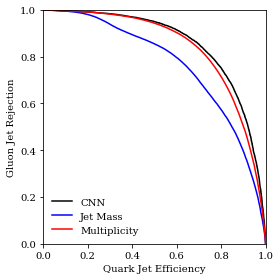

In [0]:
"""An example involving jet images and convolutional neural networks (CNNs).
The [`CNN`](../docs/archs/#cnn) class is used to provide a network architecture
based on that described in [1612.01551](https://arxiv.org/abs/1612.01551). 

Jet images are constructed using the [`pixelate`](../docs/utils/#pixelate) 
function and can be either one-channel (grayscale), meaning that only 
$p_T$ information is used, or two-channel (color), meaning that $p_T$
information and local charged particle counts are used. The images are
preprocessed by subtracting the average image in the training set and
dividing by the per-pixel standard deviations, using the 
[`zero_center`](../docs/utils/#zero_center) and 
[`standardize`](../docs/utils/#standardize) functions, respectively. 
The output of the example is a plot of the ROC curves of the CNN 
as well as the jet mass and constituent multiplicity observables.

Note that the number of epochs is quite small because it is quite time
consuming to train a CNN without a GPU (which will speed up this example
immensely).
"""

# standard library imports
from __future__ import absolute_import, division, print_function

# standard numerical library imports
import numpy as np

# energyflow imports
import energyflow as ef
from energyflow.archs import CNN
from energyflow.datasets import qg_jets
from energyflow.utils import data_split, pixelate, standardize, to_categorical, zero_center

# attempt to import sklearn
try:
    from sklearn.metrics import roc_auc_score, roc_curve
except:
    print('please install scikit-learn in order to make ROC curves')
    roc_curve = False

# attempt to import matplotlib
try:
    import matplotlib.pyplot as plt
except:
    print('please install matploltib in order to make plots')
    plt = False

################################### SETTINGS ###################################

# data controls
num_data = 220000
val_frac, test_frac = 0.1, 0.15

# image parameters
R = 0.4
img_width = 2*R
npix = 33
nb_chan = 2
norm = True

# required network architecture parameters
input_shape = (nb_chan, npix, npix)
filter_sizes = [8, 4, 4]
num_filters = [8, 8, 8] # very small so can run on non-GPUs in reasonable time

# optional network architecture parameters
dense_sizes = [50]
pool_sizes = 2

# network training parameters
num_epoch = 15
batch_size = 100

################################################################################

# load data
X, y = qg_jets.load(num_data=num_data)

# convert labels to categorical
Y = to_categorical(y, num_classes=2)

print('Loaded quark and gluon jets')

# make jet images
images = np.asarray([pixelate(x, npix=npix, img_width=img_width, nb_chan=nb_chan, 
                                 charged_counts_only=True, norm=norm) for x in X])

print('Done making jet images')

# do train/val/test split 
(X_train, X_val, X_test,
 Y_train, Y_val, Y_test) = data_split(images, Y, val=val_frac, test=test_frac)

print('Done train/val/test split')

# preprocess by zero centering images and standardizing each pixel
X_train, X_val, X_test = standardize(*zero_center(X_train, X_val, X_test))

print('Finished preprocessing')
print('Model summary:')

# build architecture
hps = {'input_shape': input_shape,
       'filter_sizes': filter_sizes,
       'num_filters': num_filters,
       'dense_sizes': dense_sizes,
       'pool_sizes': pool_sizes}
cnn = CNN(hps)

# train model
cnn.fit(X_train, Y_train,
          epochs=num_epoch,
          batch_size=batch_size,
          validation_data=(X_val, Y_val),
          verbose=1)

# get predictions on test data
preds = cnn.predict(X_test, batch_size=1000)

# get ROC curve if we have sklearn
if roc_curve:
    cnn_fp, cnn_tp, threshs = roc_curve(Y_test[:,1], preds[:,1])

    # get area under the ROC curve
    auc = roc_auc_score(Y_test[:,1], preds[:,1])
    print()
    print('CNN AUC:', auc)
    print()

    # make ROC curve plot if we have matplotlib
    if plt:

        # get multiplicity and mass for comparison
        masses = np.asarray([ef.ms_from_p4s(ef.p4s_from_ptyphims(x).sum(axis=0)) for x in X])
        mults = np.asarray([np.count_nonzero(x[:,0]) for x in X])
        mass_fp, mass_tp, threshs = roc_curve(Y[:,1], -masses)
        mult_fp, mult_tp, threshs = roc_curve(Y[:,1], -mults)

        # some nicer plot settings 
        plt.rcParams['figure.figsize'] = (4,4)
        plt.rcParams['font.family'] = 'serif'
        plt.rcParams['figure.autolayout'] = True

        # plot the ROC curves
        plt.plot(cnn_tp, 1-cnn_fp, '-', color='black', label='CNN')
        plt.plot(mass_tp, 1-mass_fp, '-', color='blue', label='Jet Mass')
        plt.plot(mult_tp, 1-mult_fp, '-', color='red', label='Multiplicity')

        # axes labels
        plt.xlabel('Quark Jet Efficiency')
        plt.ylabel('Gluon Jet Rejection')

        # axes limits
        plt.xlim(0, 1)
        plt.ylim(0, 1)

        # make legend and show plot
        plt.legend(loc='lower left', frameon=False)
        plt.show()